In [85]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Fri Nov 16 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.3
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [44]:
# %matplotlib inline
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
VISUAL_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'visual'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
EXTRA = ['age', 'sex', 'sc_bef', 'sc_aft']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)

Opening raw data file /home/miroslav/Source/thesis_project/data/processed/1a.fif...
This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-44-a857d1235d28>:29: RuntimeWarning: This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [202]:
meta_df['SEX'] = meta_df['SEX'].astype('category')
print("Women: %s " % len(meta_df['SEX'][meta_df['SEX']==0]))
print("Men: %s " % len(meta_df['SEX'][meta_df['SEX']==1]))
print("Age: \n%s" % meta_df['AGE'].describe())
print('250 Hz: %s \t 1000 Hz: %s' % (len(meta_df[meta_df['freq']==250]),len(meta_df[meta_df['freq']==1000])))

Women: 104 
Men: 29 
Age: 
count    133.000000
mean      47.706767
std        9.577263
min       30.000000
25%       39.000000
50%       49.000000
75%       55.000000
max       65.000000
Name: AGE, dtype: float64
250 Hz: 99 	 1000 Hz: 34


In [135]:
def prepare_dfs(col='lyap'):
    df = pd.read_pickle(os.path.join(LABELED_ROOT, 'training_lyap.pickle'))
    df = df.loc[:, (slice(None), col)].dropna()
    df.columns = df.columns.droplevel(1)
    df = df.astype(float)
    
    df_y = pd.read_pickle(os.path.join(LABELED_ROOT, 'labels.pickle'))
    df = df.join(df_y)
    
    extra = pd.DataFrame(index=df.index, columns=EXTRA)
    for name, row in extra.iterrows():
        extra.loc[name, 'age'] = meta_df.loc[int(name[0]), 'AGE']
        extra.loc[name, 'sex'] = meta_df.loc[int(name[0]), 'SEX']
        m1 = meta_df.loc[int(name[0]), 'M_1']
        m4 = meta_df.loc[int(name[0]), 'M_4']
        extra.loc[name, 'sc'] = int(m1) if name[1]=='a' else int(m4)
        extra.loc[name, 'sc_bef'] = m1
        extra.loc[name, 'sc_aft'] = m4
        extra.loc[name, 'change'] = m1 / m4
    df = df.join(extra)
    
    df_bef = df.loc[(slice(None), 'a'), :]
    df_bef.index = df_bef.index.droplevel(1)
    df_aft = df.loc[(slice(None), 'b'), :]
    df_aft.index = df_aft.index.droplevel(1)
    
    in_both = df_bef.join(df_aft, how='inner', lsuffix='_l').index
    df = df.loc[(in_both, slice(None)), :]
    df_bef = df_bef.loc[in_both, :]
    df_aft = df_aft.loc[in_both, :]
    df_bef.to_csv(os.path.join(LABELED_ROOT, f'{col}_bef.csv'))
    df_aft.to_csv(os.path.join(LABELED_ROOT, f'{col}_aft.csv'))
    return df, df_bef, df_aft
df, df_bef, df_aft = prepare_dfs('lyap')
df['FP1']

patient  trial
1        a         4.796633
         b         5.563548
3        a         5.445061
         b         5.102273
4        a         4.813308
         b         4.713373
5        a         4.753123
         b         4.592938
7        a         7.623793
         b         7.878171
9        a         7.416523
         b         4.847240
10       a        10.121600
         b         6.542649
11       a         4.449423
         b         4.396365
12       a         0.472917
         b         4.409591
14       a         3.761179
         b         3.928396
15       a         1.390085
         b         3.426599
16       a         4.365307
         b         4.575534
17       a         9.831416
         b         5.899423
18       a         9.038681
         b         8.654322
19       a         7.489514
         b         5.007169
                    ...    
115      a         4.365716
         b         4.541093
116      a         3.829597
         b         3.185872
117  

In [4]:
print('Men / Women: {} / {}'.format(len(df[df['sex']==1]), len(df[df['sex']==0])))
age_desc = df['age'].describe()
print('Age summary: \n{}'.format(age_desc))
m1_desc = df['sc_bef'].describe()
print('Measurement 1: \n{}'.format(m1_desc))
m2_desc = df['sc_aft'].describe()
print('Measurement 2: \n{}'.format(m2_desc))

Men / Women: 52 / 168
Age summary: 
count    220.000000
mean      48.063636
std        9.798217
min       30.000000
25%       39.000000
50%       49.000000
75%       55.000000
max       65.000000
Name: age, dtype: float64
Measurement 1: 
count    220.000000
mean      27.654545
std        4.276807
min       17.000000
25%       25.000000
50%       27.000000
75%       30.000000
max       41.000000
Name: sc_bef, dtype: float64
Measurement 2: 
count    220.000000
mean      16.972727
std        7.850730
min        2.000000
25%       11.000000
50%       17.000000
75%       23.000000
max       37.000000
Name: sc_aft, dtype: float64


# Before and after comparison plots

<IPython.core.display.Javascript object>


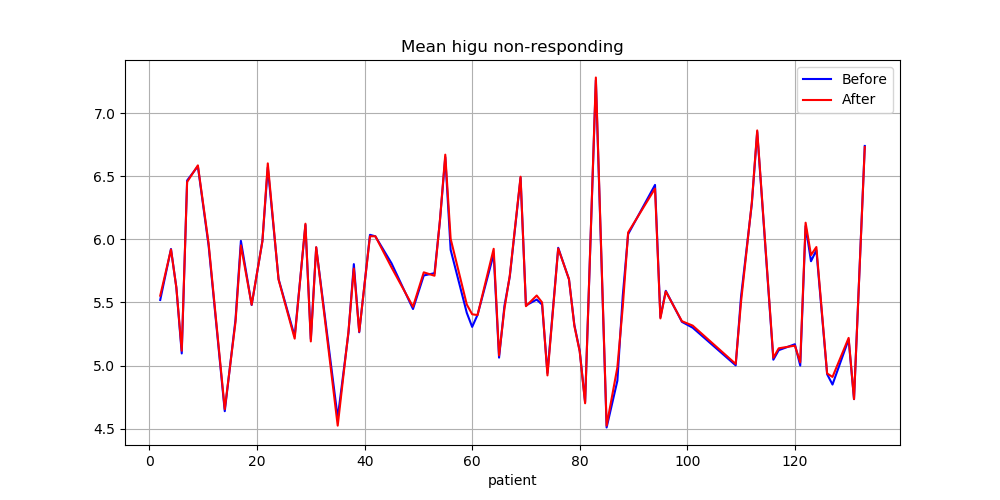

<IPython.core.display.Javascript object>


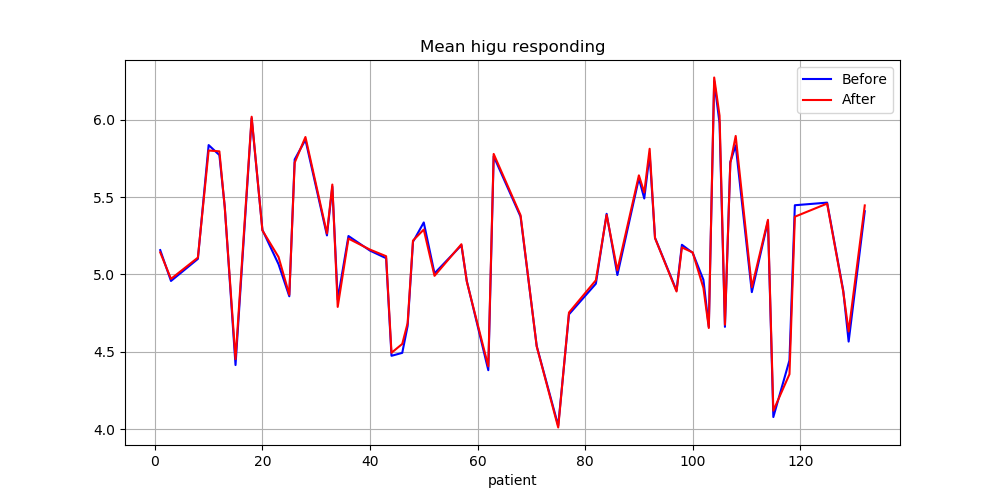

In [89]:
def plot_resp(df_bef, df_aft, m_name, resp):
    means_bef = df_bef[df_bef['label_r']==resp].mean(axis=1)
    means_aft = df_aft[df_aft['label_r']==resp].mean(axis=1)
    plt.figure(figsize=(10,5))
    ax1 = means_bef.plot(color='blue', grid=True, label='Before')
    ax2 = means_aft.plot(color='red', grid=True, label='After')
    plt.legend()
    m = 'responding' if resp else 'non-responding'
    plt.title(f'Mean {m_name} {m}')
    plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}_{m}.png'))
    plt.show()
    
def plot_measure(df_bef, df_aft, m_name):
    plot_resp(df_bef, df_aft, m_name, 0)
    plot_resp(df_bef, df_aft, m_name, 1)

# for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
for col in ['higu']:
    df, df_bef, df_aft = prepare_dfs(col)
    plot_measure(df_bef, df_aft, col)

<IPython.core.display.Javascript object>


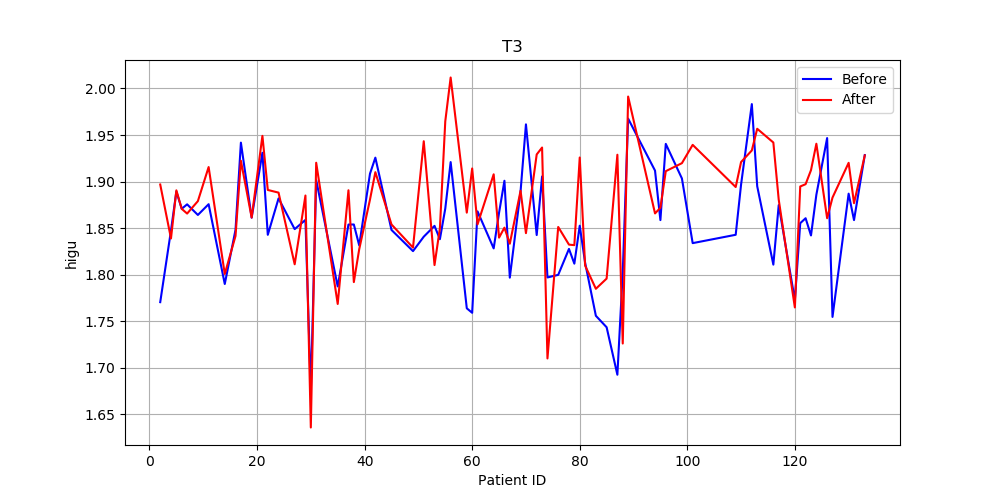

<IPython.core.display.Javascript object>


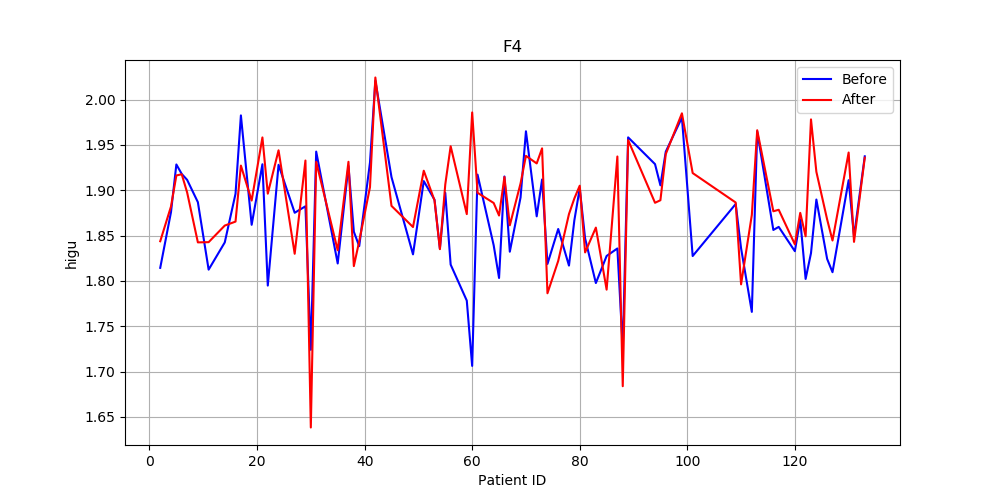

In [107]:
def plot_resp(df_bef, df_aft, m_name, chan):
    chan_bef = df_bef[chan]
    chan_aft = df_aft[chan]
    plt.figure(figsize=(10,5))
    ax1 = chan_bef.plot(color='blue', grid=True, label='Before')
    ax2 = chan_aft.plot(color='red', grid=True, label='After')
    plt.legend()
    plt.xlabel('Patient ID')
    plt.ylabel(f'{m_name}')
    plt.title(chan)
    # plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}.png'))
    plt.show()

df, df_bef, df_aft = prepare_dfs('higu')
df_bef = df_bef[df_bef['label_r']==0]
df_aft = df_aft[df_aft['label_r']==0]
plot_resp(df_bef, df_aft, 'higu', 'T3')
plot_resp(df_bef, df_aft, 'higu', 'F4')

# Before and after K-S test

In [127]:
from scipy.stats import ks_2samp

def print_res(name, res):
    if res.pvalue <= 0.02:
        m = '!!!'
    elif res.pvalue <= 0.05:
        m = '!!'
    elif res.pvalue < 0.08:
        m = '!'
    else:
        m = ''
    print('{}: \t {} \t {}'.format(name, res.pvalue, m))

def channel_wise_ks(df_bef, df_aft):
    print_res('Means', ks_2samp(df_bef.mean(axis=1), df_aft.mean(axis=1)))
    print_res('Stds', ks_2samp(df_bef.std(axis=1), df_aft.std(axis=1)))
    for col in df.loc[:, map(lambda c: not c.startswith('label'), df.columns)].columns:
        print_res(col, ks_2samp(df_bef[col], df_aft[col]))
        

# for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
for col in ['higu',]:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    print('All')
    channel_wise_ks(df_bef, df_aft)
    print('\nNon-responding')
    channel_wise_ks(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0])
    print('\nResponding')
    channel_wise_ks(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1])
    print()

print('*** LOW / HIGH DEPRESSION SCORE***')
# for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
for col in ('higu',):
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    low = df[df['sc'] <= 10]
    high = df[df['sc'] >= 30]
    channel_wise_ks(low, high)
    print()

HIGU
All
Means: 	 2.2427972692823945e-06 	 !!!
Stds: 	 0.03285721179678041 	 !!
FP1: 	 0.7352289371739013 	 
FP2: 	 0.5277539960350337 	 
F3: 	 0.21167621640177037 	 
F4: 	 0.022808348955734654 	 !!
C3: 	 0.16139873022453882 	 
C4: 	 0.5277539960350329 	 
P3: 	 0.9114984051043271 	 
P4: 	 0.3465528226516704 	 
O1: 	 0.6308526206023503 	 
O2: 	 0.3465528226516704 	 
F7: 	 0.4318757849532838 	 
F8: 	 0.21167621640177092 	 
T3: 	 0.004533972584008395 	 !!!
T4: 	 0.12112271978338932 	 
T5: 	 0.4318757849532838 	 
T6: 	 0.5277539960350345 	 
Fz: 	 0.8321899922317654 	 
Cz: 	 0.27314100870307345 	 
Pz: 	 0.16139873022453854 	 
age: 	 1.0 	 
sex: 	 1.0 	 
sc_bef: 	 1.0 	 
sc_aft: 	 1.0 	 
sc: 	 2.3332377397916916e-28 	 !!!
change: 	 1.0 	 

Non-responding
Means: 	 0.12525978367483961 	 
Stds: 	 0.47962479630262217 	 
FP1: 	 0.2607005317626961 	 
FP2: 	 0.2607005317626961 	 
F3: 	 0.26070053176269586 	 
F4: 	 0.03365520301818361 	 !!
C3: 	 0.26070053176269586 	 
C4: 	 0.6160853597389966 	 
P3:

# PCA

<IPython.core.display.Javascript object>


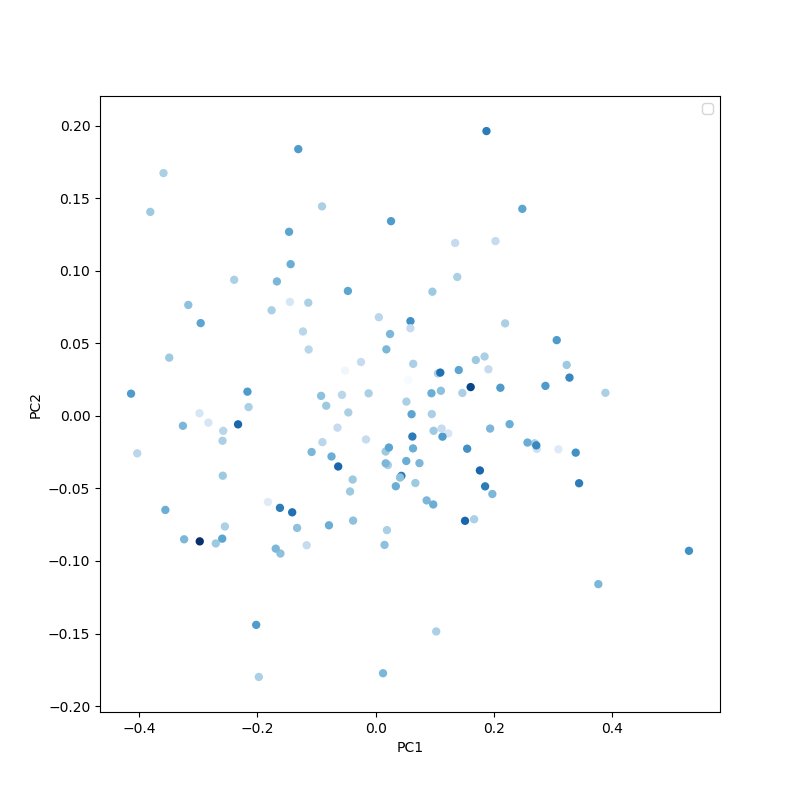

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


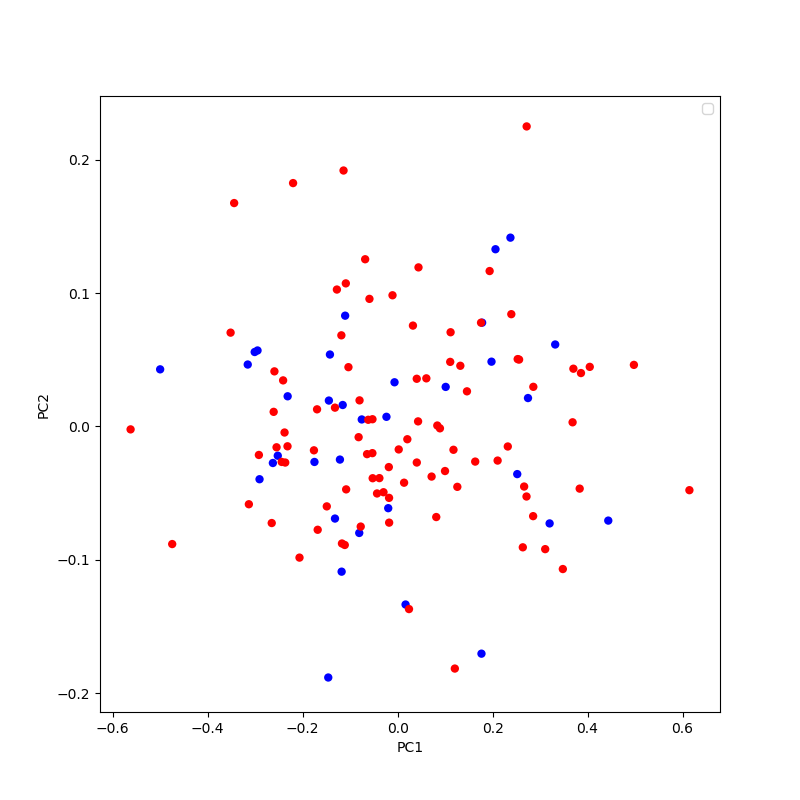

No handles with labels found to put in legend.


In [126]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

def plot_pca_2d(df_first, df_second=None, c1='blue', c2='red', title=""):
    pca = decomposition.PCA(n_components=2)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.scatter(first[:,0], first[:,1], c=c1, cmap='Blues', edgecolors='', label='')
    if second is not None:
        plt.scatter(second[:,0], second[:,1], c=c2, cmap='Reds', edgecolors='', label='')
    # plt.title(title)
    plt.legend()
    # plt.colorbar()
    plt.show()

df, df_bef, df_aft = prepare_dfs('higu')

# plot_pca_2d(df_bef, df_aft, title="Before / After")
# plot_pca_2d(df, None, c1=df['change'], title="Change in score")
plot_pca_2d(df_bef, None, c1=df_bef['sc_bef'], title="")
# plot_pca_2d(df_aft, None, c1=df_aft['sc_aft'], title="")
# plot_pca_2d(df_aft[df_aft['sc_aft'] > 27], c1='red', title="")
# plot_pca_2d(df_bef[df_bef['sc_bef'] > 30], title="")
plot_pca_2d(df[(df['sc']>30) & (df['sc']>30)], df[(df['sc'] < 20) & (df['sc'] < 20)], title="Depressed / Non-depressed")

<IPython.core.display.Javascript object>


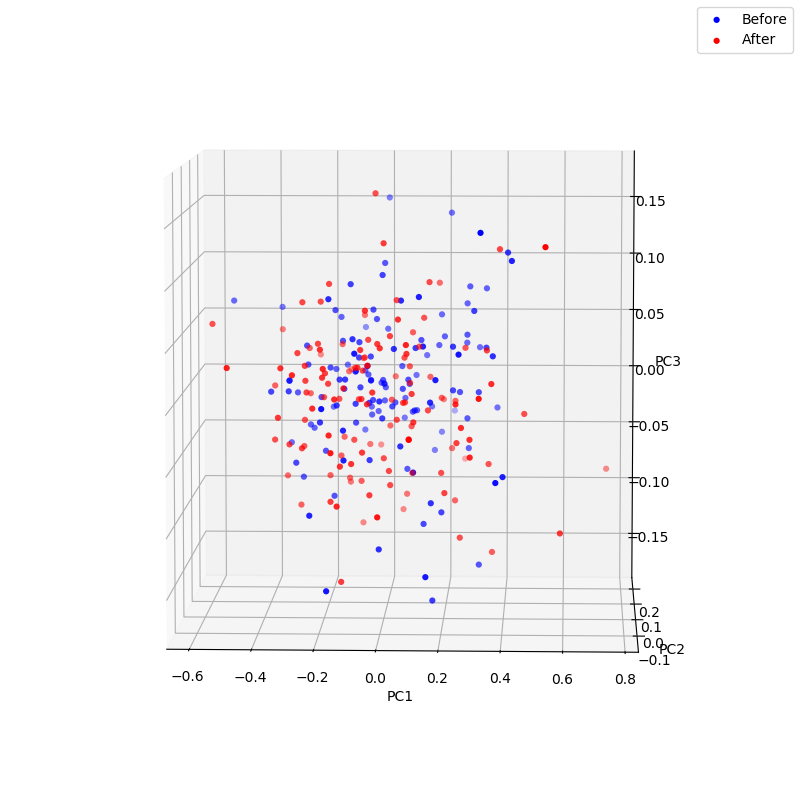

<IPython.core.display.Javascript object>


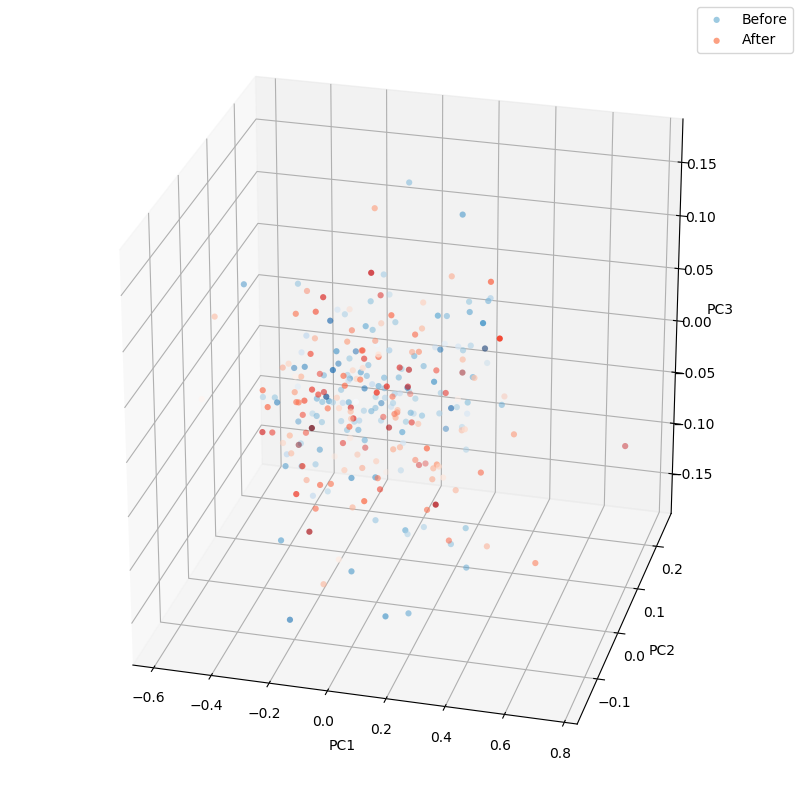

In [91]:
def plot_pca_3d(df_first, df_second=None, c1='blue', c2='red', title="", clus=False):
    pca = decomposition.PCA(n_components=3)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    if clus:
        clus_bef = df_first.iloc[(-4 < first[:,0]) & (first[:,0] < -2) & (first[:,1] < 1) & (0 < first[:,1]) & (abs(first[:,2]) < 1), :][EXTRA]
        clus_aft = df_second.iloc[(-4 < second[:,0]) & (second[:,0] < -2) & (second[:,1] < 1) & (0 < second[:,1]) & (abs(second[:,2]) < 1), :][EXTRA]
        overlap = clus_bef.join(clus_aft, how='inner', lsuffix='', rsuffix='_a')
        print(clus_bef)
        print(clus_aft)
        print(overlap.loc[:, ['age', 'sex', 'sc_bef', 'sc_aft']])
        
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.scatter(first[:,0], first[:,1], first[:,2], c=c1, cmap='Blues', edgecolor='', label='Before')
    if second is not None:
        ax.scatter(second[:,0], second[:,1], second[:,2], c=c2, cmap='Reds', edgecolor='', label='After')
    # plt.title(title)
    plt.legend()
    plt.show()

df, df_bef, df_aft = prepare_dfs('higu')

# plot_pca_3d(df_bef, df_aft, df_bef['age'], df_aft['age'])
plot_pca_3d(df_bef, df_aft, title="Before / After")
# plot_pca_3d(df[df['sex']==0], df[df['sex']==1], title="Men / Women") # Men corr cluster
plot_pca_3d(df_bef, df_aft, df_bef['sc_bef'], df_aft['sc_aft'], title="Scores bef / aft")

<IPython.core.display.Javascript object>


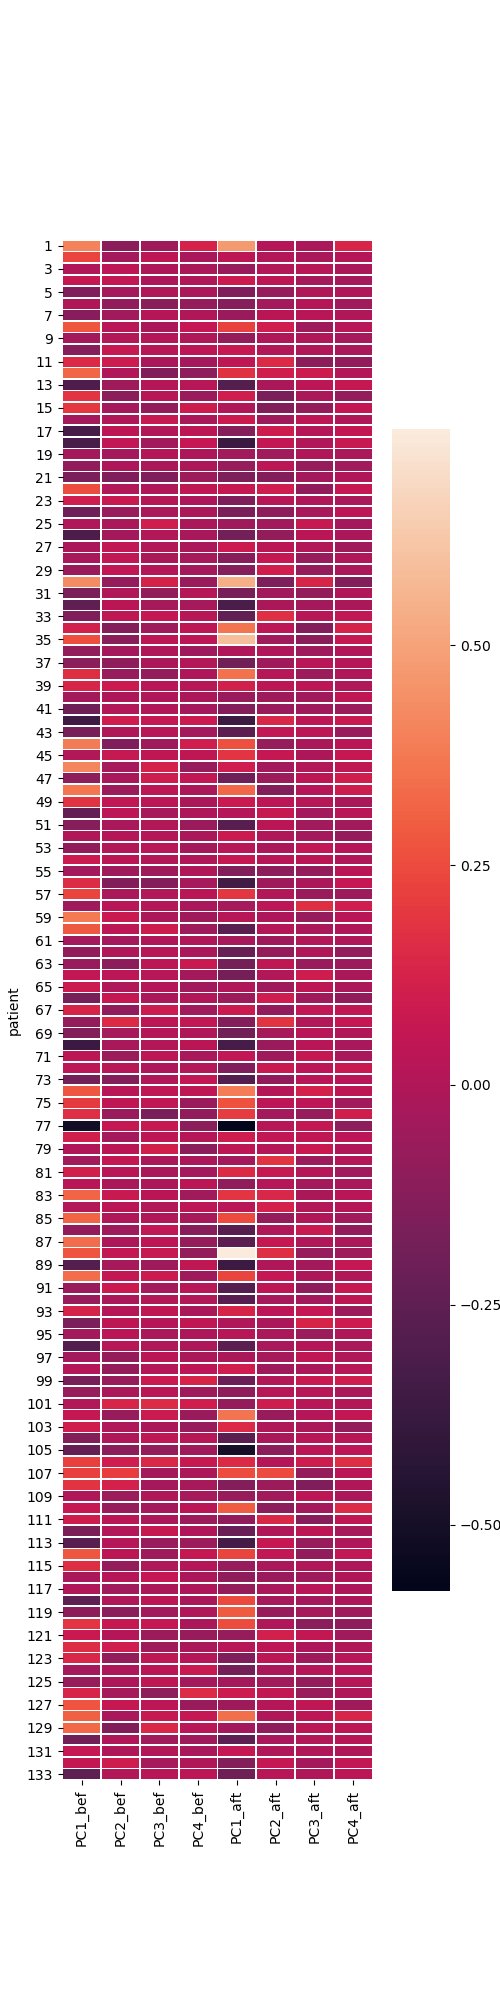

In [93]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

def plot_heatmap(df_bef=df_bef, df_aft=df_aft, n=3, title='All'):

    pca = decomposition.PCA(n_components=4)
    pca.fit(df[CHANNEL_NAMES])
    bef_proj_df = pd.DataFrame(pca.transform(df_bef[CHANNEL_NAMES]), index=df_bef.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    aft_proj_df = pd.DataFrame(pca.transform(df_aft[CHANNEL_NAMES]), index=df_aft.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])

    joined_df = bef_proj_df.join(aft_proj_df, lsuffix='_bef', rsuffix='_aft')

    plt.figure(figsize=(5, 20))
    ax = sns.heatmap(joined_df, linewidth=0.5)
    # plt.title(": ".join((measure, title)))
    plt.show()
    # plt.savefig(os.path.join(VISUAL_ROOT, "heatmaps", _".join((measure, title))+'.png'))

# for measure in ('lyap', 'corr', 'sampen'):
for measure in ('higu',):
    df, df_bef, df_aft = prepare_dfs(measure)
    plot_heatmap()
    # plot_heatmap(df_bef[df_bef['sex']==0], df_aft[df_aft['sex']==0], title='Women')
    # plot_heatmap(df_bef[df_bef['sex']==1], df_aft[df_aft['sex']==1], title='Men')
    # plot_heatmap(df_bef[df_bef['age']>50], df_aft[df_aft['age']>50], title='Age >= 50')
    # plot_heatmap(df_bef[df_bef['age']<=30], df_aft[df_aft['age']<=30], title='Age <= 30')
    # plot_heatmap(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1], title='Responding')
    # plot_heatmap(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0], title='Non-responding')
    # plot_heatmap(df_bef[df_bef['sc_bef']<25], df_aft[df_aft['sc_bef']<25], title='Score before < 25')
    # plot_heatmap(df_bef[df_bef['sc_bef']>=30], df_aft[df_aft['sc_bef']>=30], title='Score before >= 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']<25], df_aft[df_aft['sc_aft']<25], title='Score after < 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']>=30], df_aft[df_aft['sc_aft']>=30], title='Score after >= 25')
    

# Other ideas

<IPython.core.display.Javascript object>


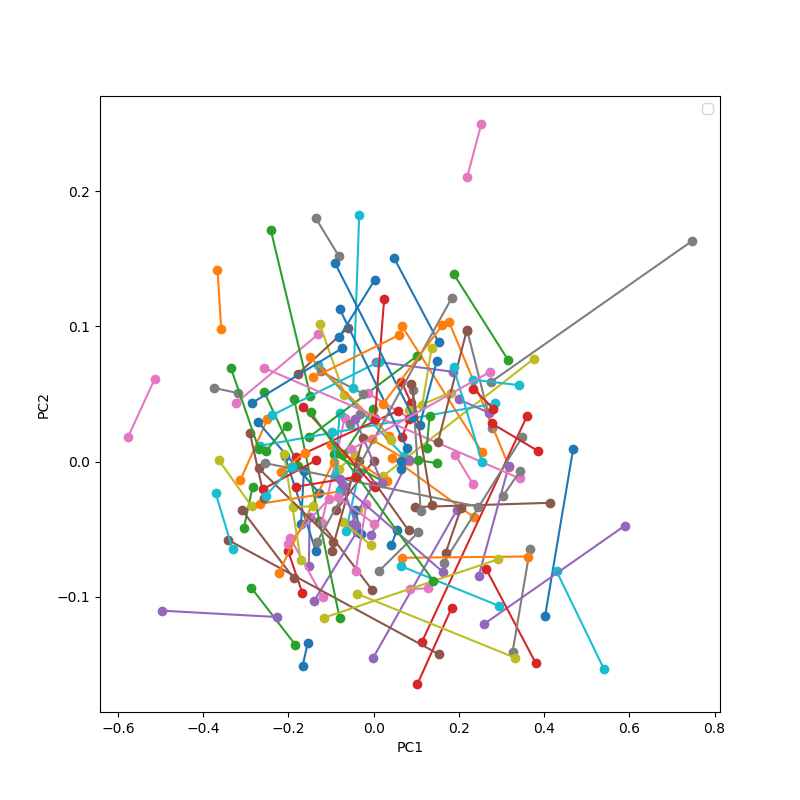

No handles with labels found to put in legend.


In [94]:
# Plot PCA, but same people with the same color

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def plot_pca_pairs_2d(df_first, df_second, title=""):
    pca = decomposition.PCA(n_components=2)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    for i in range(len(first)):
        xs = [first[i, 0], second[i, 0]]
        ys = [first[i, 1], second[i, 1]]
        plt.plot(xs, ys, 'o-')
        
    plt.title(title)
    plt.legend()
    plt.show()

df, df_bef, df_aft = prepare_dfs('higu')

plot_pca_pairs_2d(df_bef, df_aft, title="")

In [96]:
# For each person, plot their distance between before / after
from math import sqrt

def filter_by_distance(df_first, df_second, n_components=3):
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    dists = []
    for fr, sr in zip(first, second):
        dists.append(sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)])))
    perc = np.percentile(dists, 90)
    df = pd.DataFrame()
    for i, (fr, sr) in enumerate(zip(first, second)):
        dist = sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)]))
        if dist > perc:
            df = df.append(df_first.iloc[i, :]) 
    print(df.loc[:, ['label_r', 'age', 'sex', 'sc_bef', 'sc_aft', 'change']])
    

df, df_bef, df_aft = prepare_dfs('higu')

filter_by_distance(df_bef, df_aft)

     label_r   age  sex  sc_bef  sc_aft    change
34       1.0  42.0  0.0    25.0    12.0  2.083333
35       0.0  34.0  0.0    25.0    15.0  1.666667
46       1.0  37.0  0.0    24.0    11.0  2.181818
56       0.0  48.0  0.0    31.0    27.0  1.148148
59       0.0  42.0  1.0    29.0    23.0  1.260870
60       0.0  44.0  0.0    26.0    22.0  1.181818
87       0.0  30.0  0.0    28.0    24.0  1.166667
88       0.0  39.0  0.0    30.0    29.0  1.034483
108      1.0  65.0  0.0    27.0    11.0  2.454545
118      1.0  38.0  0.0    22.0     7.0  3.142857
119      1.0  61.0  1.0    23.0     4.0  5.750000
123      0.0  54.0  1.0    24.0    25.0  0.960000
127      0.0  35.0  0.0    25.0    21.0  1.190476
129      1.0  38.0  0.0    27.0     6.0  4.500000
